# **Initial Information**
---
The following dataset uses 132 URLs and obtains information pertaining to NVDA's stock, utilizing Google Search engine for our API Search. The following data's sentiments for every sentence has yet to be evaluated, and was pre-assigned sentiments based on Fin-BERT, a transformer-based sentiment classifier.


# **Forbes DataSet Cleanup**
---
The following is used to clean the forbes CSV file, and will be used as a blueprint for new data.

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import re

df = pd.read_csv("nvda_sentence_sentiment_dataset_forbes_uncleaned.csv")
df.head()

,url,date,case_text,label,score,numeric_label
0,https://www.forbes.com/sites/karlfreund/2022/01/25/meta-builds-worlds-largest-ai-supercomputer-with-nvidia-for-ai-research-and-production/,2022-01-25,"Facebook, I mean Meta, has always been one of the industry leaders when it comes to AI research and deployment.",neutral,0.858650,0
1,https://www.forbes.com/sites/karlfreund/2022/01/25/meta-builds-worlds-largest-ai-supercomputer-with-nvidia-for-ai-research-and-production/,2022-01-25,"The company processes hundreds of trillions (yes, trillions with a “T”) of inferences every day, and trains some 30,000 models daily on its current NVIDIA V100 based AI fleet. That takes a ginormous amount of processing and the load is growing rapidly, perhaps doubling every year based on previous disclosures of data center power consumption. Consequently, rumors have consistently asserted that the company would develop its own AI accelerator, much as Google has done with the TPU.",neutral,0.834046,0
2,https://www.forbes.com/sites/karlfreund/2022/01/25/meta-builds-worlds-largest-ai-supercomputer-with-nvidia-for-ai-research-and-production/,2022-01-25,"But now we know that the company appears to still love, and depend on, NVIDIA GPU’s to get the job done. Early benchmarks showed RSC can train large NLP models 3x faster and run computer vision jobs 20x ... [+] faster than the prior system So, before we get to the implications, let’s review the specs. The new system, dubbed the “RSC” (ok, Meta could use some help with naming, right?)",neutral,0.732659,0
3,https://www.forbes.com/sites/karlfreund/2022/01/25/meta-builds-worlds-largest-ai-supercomputer-with-nvidia-for-ai-research-and-production/,2022-01-25,"already has 760 DGX servers with 6,080 A100 GPUs and 1520 AMD EPYC CPUs equipped with Nvidia's Quantum InfiniBand networking system, which supports up to 200Gb/s of bandwidth..",neutral,0.795412,0
4,https://www.forbes.com/sites/karlfreund/2022/01/25/meta-builds-worlds-largest-ai-supercomputer-with-nvidia-for-ai-research-and-production/,2022-01-25,"The plan is to build that up to 16,000 GPU’s by July, which at 5 Exaflops would make it the largest known AI supercomputer in the world, beating out the US DOE Perlmutter 4 Exaflops NVIDIA-based system. PureStorage is supplying a flash subsystem growing up to an exabyte of training data, and Penguin Computing is acting as the system integrator, helping out with the setup and installation.",neutral,0.803963,0


Checking Unique URLS: (total successful scrapes out of 493)

In [80]:
unique_urls = df['url'].nunique()
print("Unique URLs:", unique_urls)

Unique URLs: 136


Damn.



## **Date Time Corrections**
---
I noticed discrepencies when loading in the correct data for dates. We will be exploring and correcting these.

In [81]:
print(df.dtypes)
df['date'] = df['date'].astype(str)
print(df.head())
print(df.shape[0])

url               object
date              object
case_text         object
label             object
score            float64
numeric_label      int64
dtype: object
                                                                                                                                          url  \
0  https://www.forbes.com/sites/karlfreund/2022/01/25/meta-builds-worlds-largest-ai-supercomputer-with-nvidia-for-ai-research-and-production/   
1  https://www.forbes.com/sites/karlfreund/2022/01/25/meta-builds-worlds-largest-ai-supercomputer-with-nvidia-for-ai-research-and-production/   
2  https://www.forbes.com/sites/karlfreund/2022/01/25/meta-builds-worlds-largest-ai-supercomputer-with-nvidia-for-ai-research-and-production/   
3  https://www.forbes.com/sites/karlfreund/2022/01/25/meta-builds-worlds-largest-ai-supercomputer-with-nvidia-for-ai-research-and-production/   
4  https://www.forbes.com/sites/karlfreund/2022/01/25/meta-builds-worlds-largest-ai-supercomputer-with-nvidia-f


Date Format: YYYY-MM-DD


,date
0,2022-01-25
1,2022-01-25
2,2022-01-25
3,2022-01-25
4,2022-01-25
...,...
3193,2025-02-04
3194,2025-02-04
3195,2025-02-04
3196,2025-02-04



Date Format: NA or Empty


,date
1243,nan
1316,nan
1429,nan
1430,nan
1431,nan
...,...
3227,nan
3228,nan
3229,nan
3230,nan



Date Format: Unknown Format


,date
1416,"Jun 10, 2022,"
1417,"Jun 10, 2022,"
1418,"Jun 10, 2022,"
1419,"Jun 10, 2022,"
1420,"Jun 10, 2022,"
...,...
3021,"Jan 27, 2025,"
3022,"Jan 27, 2025,"
3023,"Jan 27, 2025,"
3024,"Jan 27, 2025,"


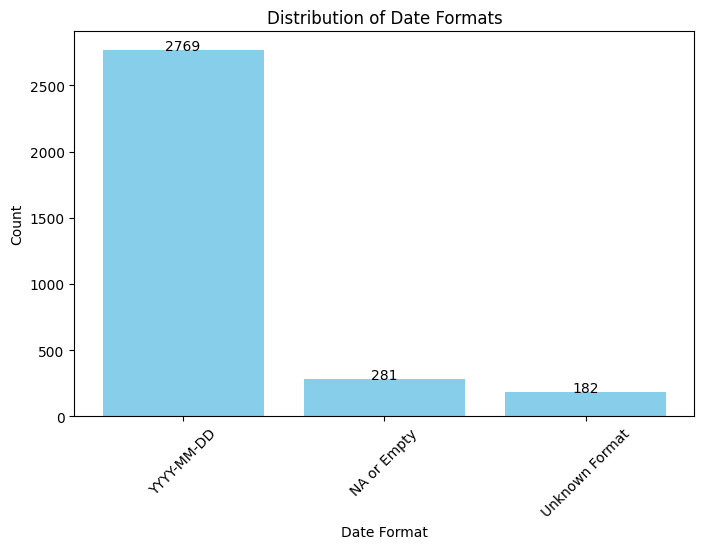

In [82]:
# Define regex patterns for different date formats
patterns = {
    'YYYY-MM-DD': r'^\d{4}-\d{2}-\d{2}$',  # ISO format
    'MMM D, YYYY': r'^[A-Za-z]{3} \d{1,2}, \d{4}$',  # Short month name
    'Month DD, YYYY': r'^[A-Za-z]+ \d{1,2}, \d{4}$',  # Full month name
    'YYYY': r'^\d{4}$',  # Year only
    'Datetime Format': r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}$',  # Full timestamp
    'NA or Empty': r'^(nan|NaT|NA)$'
}

# Function to classify date formats
def classify_format(date):
    for fmt, pattern in patterns.items():
        if re.match(pattern, date):
            return fmt
    return "Unknown Format"  # If it doesn't match known formats

# Apply classification
df['date_format'] = df['date'].apply(classify_format)

# Group the original dataset by date format
grouped_dfs = {fmt: df[df['date_format'] == fmt] for fmt in df['date_format'].unique()}

# Display each grouped DataFrame separately
for fmt, group_df in grouped_dfs.items():
    print(f"\nDate Format: {fmt}")
    display(group_df[['date']])  # Display only the date column

# Count occurrences of each format
format_counts = df['date_format'].value_counts().reset_index()
format_counts.columns = ['Date Format', 'Count']

# Visualize the results
plt.figure(figsize=(8, 5))
plt.bar(format_counts['Date Format'], format_counts['Count'], color='skyblue')
plt.xlabel('Date Format')
plt.ylabel('Count')
plt.title('Distribution of Date Formats')
plt.xticks(rotation=45)  # Rotate labels for readability


# Add count labels on top of bars
for index, value in enumerate(format_counts['Count']):
    plt.text(index, value + 1, str(value), ha='center', fontsize=10)
    
plt.show()


We can see that most of these follow the YYYY-MM-DD Format. We will fix the other format, and go back and individually input all of the NAs.

In [83]:
df['date'] = df['date'].str.strip().str.rstrip(',')

# 2. Function to convert short-month format (e.g. "Jun 10, 2022") → "YYYY-MM-DD"
def fix_short_month_date(date_str):
    """
    Tries to parse strings like 'Jun 10, 2022' into YYYY-MM-DD.
    If parsing fails, returns the original string.
    """
    try:
        # Use the format '%b %d, %Y' to parse "Jun 10, 2022"
        parsed_date = pd.to_datetime(date_str, format='%b %d, %Y')
        return parsed_date.strftime('%Y-%m-%d')
    except (ValueError, TypeError):
        # If it doesn't parse, keep the original
        return date_str

# 3. Apply to entire date column
df['date'] = df['date'].apply(fix_short_month_date)

# 2. Classification function
def classify_format(date_str):
    for fmt, pattern in patterns.items():
        if re.match(pattern, date_str):
            return fmt
    return "Unknown Format"

# 3. Apply classification to the 'date' column
df['date_format'] = df['date'].astype(str).apply(classify_format)

# 4. Count occurrences of each format
format_counts = df['date_format'].value_counts().reset_index()
format_counts.columns = ['Date Format', 'Count']

# 5. Display the results
print(format_counts)


   Date Format  Count
0   YYYY-MM-DD   2951
1  NA or Empty    281


Taking care of NA dates, we have to look to see if the url has the date posted within it. We will view the following:

In [84]:
# Filter rows where the date_format is 'NA or Empty'
nan_dates_df = df[df['date_format'] == 'NA or Empty']

# Sort the filtered DataFrame by the 'url' column
nan_dates_df = nan_dates_df.sort_values(by='url')

unique_urls = nan_dates_df['url'].nunique()
print("Unique URLs:", unique_urls)


Unique URLs: 21


We only have 21 URLS that produced NaN results. We can manually find these dates. First, we will get a full print of every single one of these URLS.

In [85]:
# Ensure Pandas doesn't truncate long strings
pd.set_option('display.max_colwidth', None)

# Extract unique URLs from the 'url' column and reset the index
unique_urls = nan_dates_df['url'].drop_duplicates().dropna().reset_index(drop=True)

# Print each URL with a numbered label
for i, url in enumerate(unique_urls, start=1):
    print(f"{i}. {url}")


1. https://councils.forbes.com/profile/Eli-David-Researcher-Lecturer/b5a70384-2c13-4600-bb28-25c8e1a22490
2. https://www.forbes.com/companies/bank-of-ny-mellon/
3. https://www.forbes.com/companies/bank-ozk/
4. https://www.forbes.com/companies/chipper-cash/
5. https://www.forbes.com/companies/dh-distributing/
6. https://www.forbes.com/companies/giant-eagle/
7. https://www.forbes.com/companies/jefferies-financial/
8. https://www.forbes.com/companies/mcconnell-jones/
9. https://www.forbes.com/companies/novo/
10. https://www.forbes.com/companies/schindler-holding/
11. https://www.forbes.com/companies/shenzhou-international-group-holdings/
12. https://www.forbes.com/pictures/6272f1a9d280e0fda2bb66d0/claire-delaunay-vice-pres/
13. https://www.forbes.com/pictures/6272f1a9d280e0fda2bb66d0/daniel-dines-confounder-a/
14. https://www.forbes.com/profile/matthew-fleissig/
15. https://www.forbes.com/sites/investor-hub/article/best-growth-stocks-for-next-5-years/
16. https://www.forbes.com/sites/inve

**I went into these websites manually to find the dates: **

1. https://councils.forbes.com/profile/Eli-David-Researcher-Lecturer/b5a70384-2c13-4600-bb28-25c8e1a22490 - Drop
2. https://www.forbes.com/companies/bank-of-ny-mellon/ - Contains current data, 2025-02-19
3. https://www.forbes.com/companies/bank-ozk/ - 2025-02-19
4. https://www.forbes.com/companies/chipper-cash/ - 2025-02-19
5. https://www.forbes.com/companies/dh-distributing/ - Drop
6. https://www.forbes.com/companies/giant-eagle/ - Drop
7. https://www.forbes.com/companies/jefferies-financial/ - 2025-02-19
8. https://www.forbes.com/companies/mcconnell-jones/ - 2025-02-19
9. https://www.forbes.com/companies/novo/ - 2025-02-19
10. https://www.forbes.com/companies/schindler-holding/ - 2025-02-19
11. https://www.forbes.com/companies/shenzhou-international-group-holdings/ - 2025-02-19
12. https://www.forbes.com/pictures/6272f1a9d280e0fda2bb66d0/claire-delaunay-vice-pres/ - 2022-05-14
13. https://www.forbes.com/pictures/6272f1a9d280e0fda2bb66d0/daniel-dines-confounder-a/ - 2022-05-04
14. https://www.forbes.com/profile/matthew-fleissig/ - Drop
15. https://www.forbes.com/sites/investor-hub/article/best-growth-stocks-for-next-5-years/ - 2025-02-02
16. https://www.forbes.com/sites/investor-hub/article/nvidia-earnings-what-to-know-stock-report-q1-2025/ - 2025-02-15
17. https://www.forbes.com/sites/investor-hub/article/nvidia-vs-amd-vs-intel-best-ai-stock-to-buy/ - 2025-02-04
18. https://www.forbes.com/sites/investor-hub/article/top-sectors-growth-stocks-next-decade/ - 2025-02-13
19. https://www.forbes.com/sites/investor-hub/article/where-will-nvidia-nvda-stock-be-5-years/ - 2024-08-26
20. https://www.forbes.com/video/6315575904112/walmart-heir-unseated-as-richest-women-in-the-world/ - 2022-11-15
21. https://www.forbes.com/video/6343611552112/how-this-nvidia-cofounder-got-a-quantum-computer-for-rpi/ - 2023-12-20

In [86]:

# 1. Create a mapping of URL -> new date (or "Drop")
url_updates = {
    "https://councils.forbes.com/profile/Eli-David-Researcher-Lecturer/b5a70384-2c13-4600-bb28-25c8e1a22490": "Drop",
    "https://www.forbes.com/companies/bank-of-ny-mellon/": "2025-02-19",
    "https://www.forbes.com/companies/bank-ozk/": "2025-02-19",
    "https://www.forbes.com/companies/chipper-cash/": "2025-02-19",
    "https://www.forbes.com/companies/dh-distributing/": "Drop",
    "https://www.forbes.com/companies/giant-eagle/": "Drop",
    "https://www.forbes.com/companies/jefferies-financial/": "2025-02-19",
    "https://www.forbes.com/companies/mcconnell-jones/": "2025-02-19",
    "https://www.forbes.com/companies/novo/": "2025-02-19",
    "https://www.forbes.com/companies/schindler-holding/": "2025-02-19",
    "https://www.forbes.com/companies/shenzhou-international-group-holdings/": "2025-02-19",
    "https://www.forbes.com/pictures/6272f1a9d280e0fda2bb66d0/claire-delaunay-vice-pres/": "2022-05-14",
    "https://www.forbes.com/pictures/6272f1a9d280e0fda2bb66d0/daniel-dines-confounder-a/": "2022-05-04",
    "https://www.forbes.com/profile/matthew-fleissig/": "Drop",
    "https://www.forbes.com/sites/investor-hub/article/best-growth-stocks-for-next-5-years/": "2025-02-02",
    "https://www.forbes.com/sites/investor-hub/article/nvidia-earnings-what-to-know-stock-report-q1-2025/": "2025-02-15",
    "https://www.forbes.com/sites/investor-hub/article/nvidia-vs-amd-vs-intel-best-ai-stock-to-buy/": "2025-02-04",
    "https://www.forbes.com/sites/investor-hub/article/top-sectors-growth-stocks-next-decade/": "2025-02-13",
    "https://www.forbes.com/sites/investor-hub/article/where-will-nvidia-nvda-stock-be-5-years/": "2024-08-26",
    "https://www.forbes.com/video/6315575904112/walmart-heir-unseated-as-richest-women-in-the-world/": "2022-11-15",
    "https://www.forbes.com/video/6343611552112/how-this-nvidia-cofounder-got-a-quantum-computer-for-rpi/": "2023-12-20"
}

# 2. Loop over each URL in the mapping
for url, date_val in url_updates.items():
    if date_val == "Drop":
        # Remove rows matching this URL
        df = df[df['url'] != url]
    else:
        # Update the date for rows matching this URL
        df.loc[df['url'] == url, 'date'] = date_val

# 3. (Optional) Check how many rows remain and preview
print(f"DataFrame now has {len(df)} rows.")


DataFrame now has 3219 rows.


1 Final check to ensure all the dates are formatted correctly:

In [87]:
# 3. Apply classification to the 'date' column
df['date_format'] = df['date'].astype(str).apply(classify_format)

# 4. Count occurrences of each format
format_counts = df['date_format'].value_counts().reset_index()
format_counts.columns = ['Date Format', 'Count']

# 5. Display the results
print(format_counts)

  Date Format  Count
0  YYYY-MM-DD   3219


## **Class Imbalances**
---
The following are to address class imbalances for the forbes pulled data:


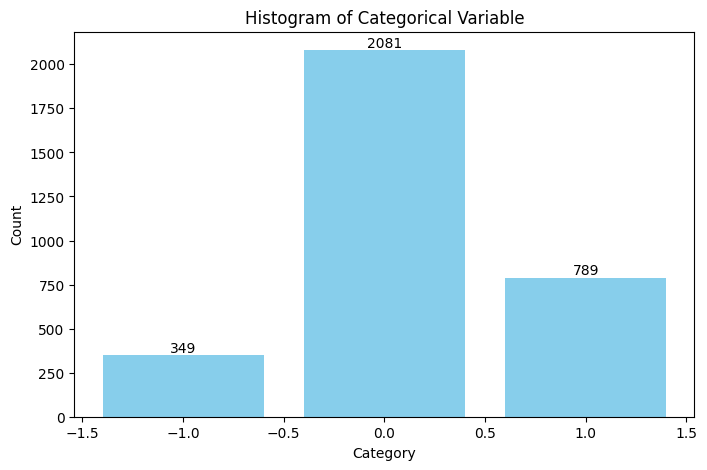

In [88]:
# Count occurrences of each category
category_counts = df['numeric_label'].value_counts()

# Plot histogram
plt.figure(figsize=(8,5))
bars = plt.bar(category_counts.index, category_counts.values, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Histogram of Categorical Variable')

# Add numeric labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{int(height)}', 
             ha='center', va='bottom', fontsize=10)

plt.show()


### Hotfix: Undersampling

We will be saving 2 seperate files therefore: an under-sampled file that contains equal parts of sentiment for all data (for immediate training), and the full, cleaned dataset, which we will prune later.

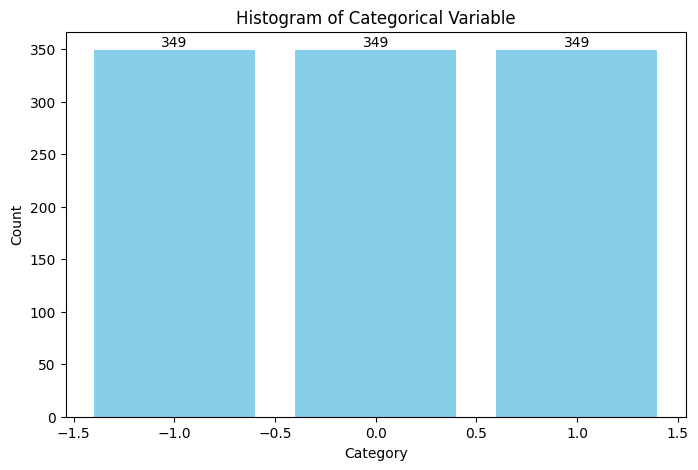

In [89]:


# 2. Undersample to balance classes
#    Let's assume your classes are in the column 'numeric_label'
class_counts = df['numeric_label'].value_counts()
min_count = class_counts.min()

# For each class, sample 'min_count' rows
balanced_dfs = []
for sentiment_value in class_counts.index:
    class_df = df[df['numeric_label'] == sentiment_value]
    class_df_undersampled = class_df.sample(n=min_count, random_state=42)
    balanced_dfs.append(class_df_undersampled)

# Combine them into a balanced DataFrame
df_undersampled = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)


category_counts = df_undersampled['numeric_label'].value_counts()

# Plot histogram
plt.figure(figsize=(8,5))
bars = plt.bar(category_counts.index, category_counts.values, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Histogram of Categorical Variable')

# Add numeric labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{int(height)}', 
             ha='center', va='bottom', fontsize=10)

plt.show()



In [90]:
df_undersampled.to_csv("sentiment_data.csv", index=False)
df.to_csv("nvda_sentence_sentiment_dataset_forbes_cleaned.csv", index=False)
print("Files saved:\n- nvda_sentence_sentiment_dataset_forbes_cleaned.csv (full dataset)\n- sentiment_data.csv (undersampled, balanced dataset)")


Files saved:
- nvda_sentence_sentiment_dataset_forbes_cleaned.csv (full dataset)
- sentiment_data.csv (undersampled, balanced dataset)


# **Future Work:**
---
I will come back to the cleaned dataset and manually classify sentiment with a friend of mine in finance. We will then use this dataset to train sentiment instead of pre-trained Fin-BERT sentiments. This will take a while, and as we expand to more financial information, we will need to look into alternative methods.

### Current Help Needed:
---
If you can Work on 
 - data augmentation via synonym translation, back translating, and/or creating textual embeddings with the -1 and +1 samples of this dataset
 - Using SMOTE to create new data for -1 samples and +1 samples

That will be greatly appreciated.
